## Import Libraries

In [1]:
import sys

sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from tests.training import *
from skimage import io, color
from utils.utils import set_global_seed
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
set_global_seed(42)

/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Set Directories

In [2]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [3]:
#config = get_config()
#train_loader, val_loader, test_loader = create_dataset(config, transform=False, noisy_data=True, noisy_factor=0, gaus_factor=3400)

In [4]:
# # Crea la figura con 1 riga e 2 colonne
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# # Primo subplot
# ax1.imshow(dataset[0][0])
# ax1.set_title('Non-noisy')

# #Secondo subplot
# ax2.imshow(noisy_dataset[0][0])
# ax2.set_title('Noisy')
# # Mostra il grafico
# plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
# plt.show() 


## Create Model

### Swin2SR

In [5]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)



model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/itzgpbbqswin2sr'))

<All keys matched successfully>

## Inference

In [6]:
# from torch import nn as nn
# # Validation loop (optional but recommended)
# model.eval()  # Set model to evaluation mode
# model = model.cuda()
# criterion = nn.MSELoss()
# val_loss = 0.0
# test_inputs = []
# test_outputs = []
# test_targets = []
# test_inputs_denormalized =[]
# test_outputs_denormalized=[]
# test_targets_denormalized = []

# c1_min, c1_max, c2_min, c2_max = test_loader.dataset.get_normalization_params() #of the entire dataset
# print(c1_max, c2_max, c1_min, c2_min)

# with torch.no_grad():
#     for inputs, targets in test_loader:
#         inputs, targets = inputs.cuda(), targets.cuda()                

#         # Ensure inputs and targets have the correct dimensions
#         if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
#             inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
#         if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
#             targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, targets)  # Compute loss
        
#         val_loss += loss.item()  # Accumulate loss
        
        
#         targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
#         targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
#         outputs[:,0,:,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
#         outputs[:,1,:,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
        
        
#         test_inputs.append(inputs.cpu().numpy())
#         test_outputs.append(outputs.cpu().numpy())
#         test_targets.append(targets.cpu().numpy())        

#         # Ensure outputs and targets have the same dimensions for loss computation
#         if outputs.shape != targets.shape:
#             print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
#             raise ValueError("Output and target shapes do not match!")       

# test_inputs = np.concatenate(test_inputs, axis=0)
# test_outputs = np.concatenate(test_outputs, axis=0)
# test_targets = np.concatenate(test_targets, axis=0)



# # Compute average validation loss for the epoch
# val_loss = val_loss / len(test_loader)
# print(f'Validation Loss: {val_loss:.9f}')


## Metric Calculation

In [7]:
# from collections import defaultdict
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim
# from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
# from core.psnr import PSNR

# psnr_arr = {0: [], 1: []}
# ssim_arr = defaultdict(list)


# for ch_idx in range(test_outputs.shape[1]):
#     if ch_idx == 0:
#         data_range = c1_max - c1_min
#     else: 
#         data_range = c2_max - c2_min
#     psnr_arr[ch_idx].append(PSNR(test_targets[:, ch_idx, :, :], test_outputs[:, ch_idx, : , : ], range_= data_range))
# print(psnr_arr)
# print("psnr channel 1:", np.mean(psnr_arr[0]))
# print("psnr channel 2:", np.mean(psnr_arr[1]))

## Visual Evaluation

In [8]:
# idx = 3
# print(f"Index: {idx}")
# img_sz = 3
# ncols = 3
# nrows = 2
# _, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
# ax[0,0].imshow(test_inputs[idx ,0])
# ax[0,1].imshow(test_outputs[idx, 0],vmin = test_targets[idx, 0].min())
# ax[0,2].imshow(test_targets[idx, 0])
# ax[1,1].imshow(test_outputs[idx,1], vmin = test_targets[idx, 1].min())
# ax[1,2].imshow(test_targets[idx,1])

# ax[0,0].set_title('Noisy Input')
# ax[0,1].set_title('Output')
# ax[0,2].set_title('Target')

## Stitching Predictions


In [ ]:
data_type = 'biosr'
gauss_factor = 13600
poisson_factor = 0
noisy_data = False
patch_size = 256
tile_size = 128

In [9]:
from predtiler.dataset import get_tiling_dataset, get_tile_manager
from data_loader.biosr_dataloader import SplitDataset

data_shape = (5, 1004, 1004) 
manager = get_tile_manager(data_shape=data_shape, tile_shape=(1,tile_size,tile_size), 
                               patch_shape=(1,patch_size,patch_size))

    
dset_class = get_tiling_dataset(SplitDataset, manager)
dataset = dset_class(           data_type = data_type,
                                patch_size=patch_size,
                                transform=None,
                                noisy_data=noisy_data,
                                noise_factor=poisson_factor, 
                                gaus_factor=gauss_factor,
                                mode = 'Test'
                                )
print(type(dataset))
test_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=4)
c1_min, c1_max, c2_min, c2_max = test_loader.dataset.get_normalization_params() #of the entire dataset

Norm Param:  0.0 0.0 65535.0 65535.0 94844.0 0.0
c1_data shape: (1004, 1004, 5)
c2_data shape: (1004, 1004, 5)
<class 'predtiler.dataset.get_tiling_dataset.<locals>.TilingDataset'>


In [10]:
print(manager)

TileIndexManager(data_shape=(5, 1004, 1004), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)


In [11]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
model = model.eval()
model = model.cuda()

for inp, targ in test_loader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    pred = model(inp)
    
    
    pred[:,0,:,:] = pred[:,0,:,:]*(c1_max - c1_min) + c1_min
    pred[:,1,:,:] = pred[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    predictions.append(pred.cpu().detach().numpy())
    
    
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    targets.append(targ.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis = 0) # shape: (number_of_patches, C, patch_size, patch_size)
stitched_pred = stitch_predictions(predictions, dataset.tile_manager)
targets = np.concatenate(targets, axis = 0)
print(targets.shape)
print(manager)
print(predictions.shape)
print(stitched_pred.shape)

[5, 1004, 1004, 2]
(245, 2, 256, 256)
TileIndexManager(data_shape=(5, 1004, 1004), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)
(245, 2, 256, 256)
(5, 1004, 1004, 2)


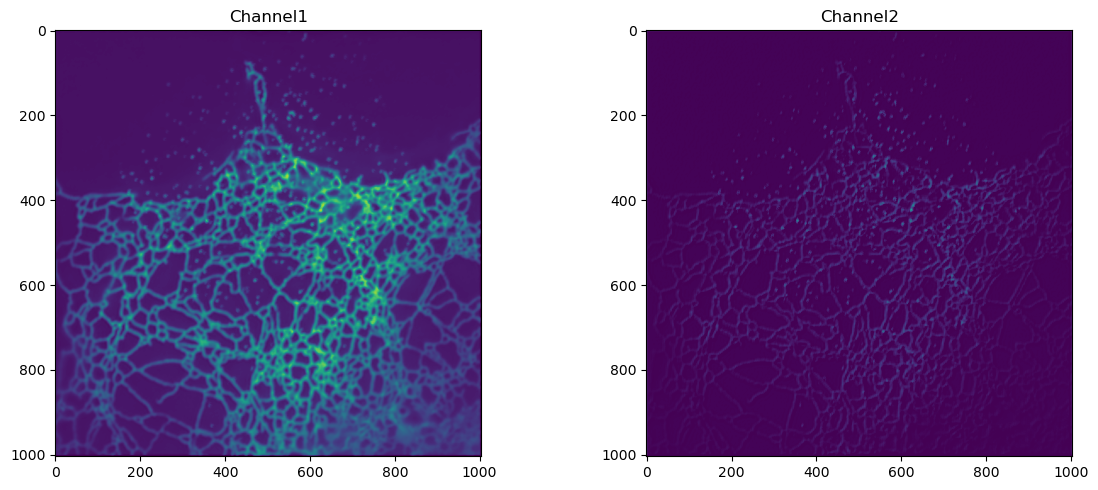

In [12]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# Primo subplot
ax1.imshow(stitched_pred[4,:, :,0], vmin =  targets[4,0,:,:].min(), vmax =  targets[0,0,:,:].max())
ax1.set_title('Channel1')

# Secondo subplot
ax2.imshow(stitched_pred[4,:, :,1], vmin =  targets[4,1,:,:].min(), vmax =  targets[0,1,:,:].max())
ax2.set_title('Channel2')
# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()


In [13]:
from data_loader.biosr_no_patching import NoPatchingSplitDataset
dataset_no_patching = NoPatchingSplitDataset(
                              data_type=data_type,
                              transform=None,
                              noisy_data=noisy_data,
                              noise_factor= poisson_factor, 
                              gaus_factor= gauss_factor, mode = 'Test')


dataloader = DataLoader(dataset_no_patching, batch_size=2, shuffle=False, num_workers=4)
c1_min, c1_max, c2_min, c2_max = test_loader.dataset.get_normalization_params() #of the entire dataset

Norm Param:  0.0 0.0 65535.0 65535.0 94844.0 0.0
c1_data shape: (1004, 1004, 5)
c2_data shape: (1004, 1004, 5)


In [14]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
for inp, targ in dataloader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    targets.append(targ.cpu().detach().numpy())
    
targets = np.concatenate(targets, axis = 0)
print(targets.shape)

(5, 2, 1004, 1004)


In [15]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
for ch_idx in range(targets.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
        
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(targets[:,ch_idx,:,:], stitched_pred[:,:,:,ch_idx], range_= data_range))

print(psnr_arr)
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))


{0: [tensor([28.9286, 28.5311, 29.4229, 32.3004, 28.7558])], 1: [tensor([28.7697, 29.4920, 30.5788, 30.6255, 29.8397])]}
psnr channel 1: 29.58775
psnr channel 2: 29.861124


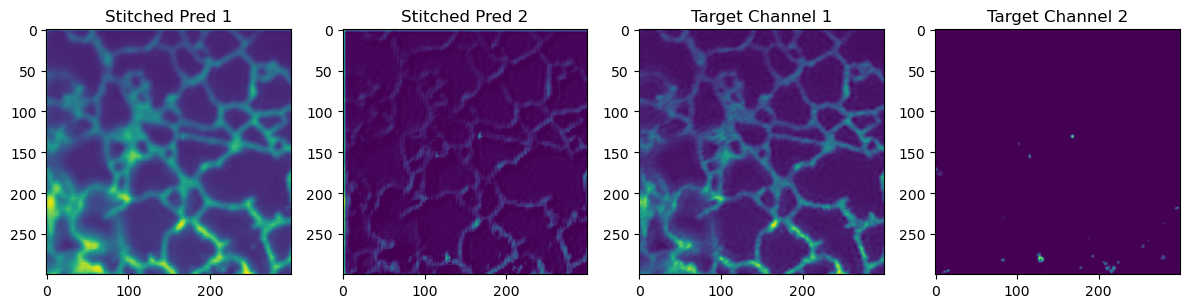

In [16]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))  # 1 riga, 2 colonne

inputs, target = dataloader.dataset[0]


# Primo subplot
ax1.imshow(stitched_pred[0,:,:,0][:300,:300],vmin = targets[0,0,:,:].min())
ax1.set_title('Stitched Pred 1')

# Secondo subplot
ax2.imshow(stitched_pred[0,:,:,1][:300,:300],vmin = targets[0,1,:,:].min())
ax2.set_title('Stitched Pred 2')

# Secondo subplot
ax3.imshow(targets[0,0,:, :][:300,:300])
ax3.set_title('Target Channel 1')


# Secondo subplot
ax4.imshow(targets[0,1,:,:][:300,:300])
ax4.set_title('Target Channel 2')

# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()

In [17]:
print(targets[:, 0, :, :].max())
print(stitched_pred[:, 0,:, :].max())
print(targets[:, 0, :, :].min())
print(stitched_pred[:, 0,:, :].min())

65535.0
29262.316
0.0
-8713.032


In [18]:
directory = '/group/jug/ashesh/TrainValTestSplit/hagen'
val = np.load(os.path.join(directory, 'val_data.npy'), allow_pickle=True)
print(val.shape)

(10, 2048, 2048, 2)


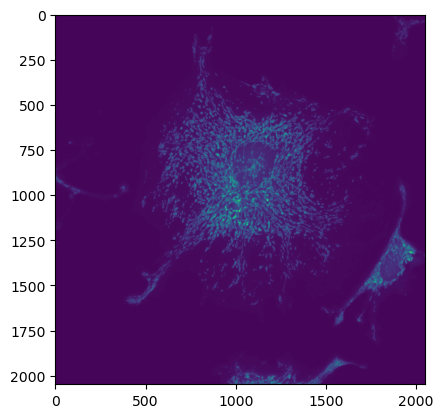

In [19]:
plt.imshow(val[0,:,:,1])